<a href="https://colab.research.google.com/github/GiovanniPioDelvecchio/GCNs_on_text/blob/issue%232/GNN_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stanza
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=5b59f378e55a853c9a4fa5447fff082c18a8b9e9b0aa95f7cb069b5184fc338d
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils

Saving utils.py to utils.py


INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| constituency | wsj       |
| depparse     | combined  |
| sentiment    | sstplus   |
| ner          | ontonotes |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


glove path missing
Utils have been correctly loaded


In [3]:
#import utils
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import save, load
import torch.nn as nn

from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, InMemoryDataset
from torch_geometric.utils import scatter
from torch_geometric.data import download_url

from torch_geometric.nn import GCNConv, GATv2Conv, global_mean_pool
import torch.nn.functional as F
from torch.nn import Linear, Dropout

from functools import partial
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import PolynomialLR
from torch_geometric.nn.pool import global_max_pool
from torch.optim.lr_scheduler import OneCycleLR

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
tweet_list_train = []
sentiment_list_train = []
tweet_list_test = []
sentiment_list_test = []
cv19_graph_data_train = utils.Dataset_from_sentences("train", "/content/processed_train/",
                                                     "/content/drive/MyDrive/GraphDataset/train/",
                                                     tweet_list_train, sentiment_list_train)
cv19_graph_data_test = utils.Dataset_from_sentences("test", "/content/processed_test/",
                                                    "/content/drive/MyDrive/GraphDataset/test/",
                                                    tweet_list_test, sentiment_list_test)
strat_train = load("/content/drive/MyDrive/StratifiedSplit/strat_train.pt")
strat_val = load("/content/drive/MyDrive/StratifiedSplit/strat_val.pt")
print("Loaded training dataset:")
print(cv19_graph_data_train)
print("Loaded test dataset:")
print(cv19_graph_data_test)
print("Loaded training and validation sets as result of stratified k-fold:")
print(strat_train)
print(strat_val)

['/content/processed_train//train.pt']
['/content/processed_test//test.pt']
Loaded training dataset:
Dataset_from_sentences(25948)
Loaded test dataset:
Dataset_from_sentences(6487)
Loaded training and validation sets as result of stratified k-fold:
Dataset_from_sentences(22704)
Dataset_from_sentences(3244)


In [7]:
# GCN definition
class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, n_filters, dim_out):
    super().__init__()

    self.first_linear = Linear(dim_in, dim_in)

    self.gcn_list_1 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_2 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])
    self.gcn_list_3 = torch.nn.ModuleList([GCNConv(dim_in, dim_in, add_self_loops = True)
                                         for i in range(0, n_filters)])

    #self.gcn_1 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_2 = GCNConv(dim_in, dim_in, add_self_loops = True)
    #self.gcn_3 = GCNConv(dim_in, dim_in, add_self_loops = True)
    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gcn_l in enumerate(self.gcn_list_1):
        h = x + gcn_l(x, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_2[i](h, edge_index)
        h = h.tanh()
        h = h + self.gcn_list_3[i](h, edge_index)
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)


    """
    h = self.first_linear(x)
    h = h + self.gcn_1(h, edge_index)
    h = h + self.gcn_2(h, edge_index)
    h = h + self.gcn_3(h, edge_index)
    if enable_log:
        visualize_hidden_graph(x, edge_index)
    h = global_mean_pool(h, batch)
    h = self.classifier(h)
    """

    return h_layers

In [8]:
# actual GAT class
# this must be modified
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, n_filters, dim_out, heads= 8):
    super().__init__()
    # dim_in is the number of node features, dim_h is the dimension
    # of the hidden layer, dim_out is the dimension of the output
    # feature vector
    self.first_linear = Linear(dim_in, dim_in)

    self.gat_list_1 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_2 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])
    self.gat_list_3 = torch.nn.ModuleList([GATv2Conv(dim_in, dim_in // heads, heads = heads)
                                         for i in range(0, n_filters)])

    self.l_list = torch.nn.ModuleList([Linear(dim_in, 1)
                                      for i in range(0, n_filters)])
    self.classifier = Linear(n_filters, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=1e-3,
                                      weight_decay=5e-5)

  def forward(self, x, edge_index, batch, enable_log = False):
    # the parameters of the forward correspond to data.x and data.edge_index
    # where data is a Data object like those described above;
    if enable_log:
        utils.visualize_hidden_graph(x, edge_index)

    #h = self.first_linear(x)

    h_list = []
    for i, gat_l in enumerate(self.gat_list_1):
        #print(f"shape of initial tensor x: {x.shape}")
        h = x + gat_l(x, edge_index)
        #print(f"shape of the first residual: {h.shape}")
        h = h.tanh()
        h = h + self.gat_list_2[i](h, edge_index)
        #print(f"shape of the second residual: {h.shape}")
        h = h.tanh()
        h = h + self.gat_list_3[i](h, edge_index)
        #print(f"shape of the third residual: {h.shape}")
        if enable_log:
            print("h shape: " + str(h.shape))
            utils.visualize_hidden_graph(h, edge_index)
        h = global_mean_pool(h, batch)
        #print(f"shape of the tensor after global mean pool: {h.shape}")
        h = self.l_list[i](h)
        h_list.append(h)

    h_layers = torch.hstack(h_list)
    #print(h_layers.shape)
    h_layers = self.classifier(h_layers)
    return h_layers

In [9]:
class EarlyStopper:
  def __init__(self, patience=1, min_delta=0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss):
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over the course of training.
    Args:
        train_losses: A list of training losses.
        val_losses: A list of validation losses.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [24]:
def train(model, strat_train, strat_val, partial_scheduler, epochs = 30, batch_size = 30, print_every = 1, path='Model'):
    """Train a GNN model and return the trained model."""
    batch_size = batch_size
    criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.01)
    optimizer = model.optimizer
    scheduler = partial_scheduler(optimizer)
    print(type(scheduler))
    loader_train =  DataLoader(strat_train.data_list, batch_size=batch_size, shuffle=True)
    loader_val = DataLoader(strat_val.data_list, batch_size=batch_size, shuffle=True)
    model.train()
    early_stopper = EarlyStopper(patience=10, min_delta=0.2)

    train_losses = []
    val_losses = []

    best_model = []
    best_acc_val = 0
    epochs_to_return = 0

    #scheduler.step()
    for epoch in range(epochs+1):
      mean_loss_train = 0
      mean_acc_train = 0
      for i, batch in enumerate(loader_train):
        # Training

        out = model(batch.x, batch.edge_index, batch.batch)
        loss_train = criterion(out, batch.y.long())
        mean_loss_train += loss_train.item()

        acc_train = accuracy(out.argmax(dim=1), batch.y)
        mean_acc_train += acc_train
        loss_train.backward()
        with torch.no_grad():
            optimizer.step()
            if type(scheduler) == OneCycleLR:
                scheduler.step()
            optimizer.zero_grad()
      mean_loss_train /= (i + 1)
      mean_acc_train /= (i + 1)
      train_losses.append(mean_loss_train)
      if type(scheduler) != OneCycleLR:
          scheduler.step()

      mean_loss_val = 0
      mean_acc_val = 0
      #model.eval()
      with torch.no_grad():
          for i, batch in enumerate(loader_val):
            out = model(batch.x, batch.edge_index, batch.batch)
            loss_val = criterion(out, batch.y.long())
            mean_loss_val += loss_val.item()
            acc_val = accuracy(out.argmax(dim=1), batch.y)
            mean_acc_val += acc_val
            #visualize_embedding(embed, batch.y, epoch, loss_val)
          mean_loss_val /= (i + 1)
          mean_acc_val /= (i + 1)
          val_losses.append(mean_loss_val)
          if mean_acc_val > best_acc_val:
                best_acc_val = mean_acc_val
                best_model = copy.deepcopy(model)
                epochs_to_return = epoch
          if epoch % 15 == 0 and epoch > 0:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.optimizer.state_dict(),
            'loss': mean_loss_train,
            }, path + '_ckpt')
       # model.train()

      if(epoch % print_every == 0):
        print(f'Epoch {epoch:>3} | Train Loss: {mean_loss_train:.3f} | Train Acc: '
              f'{mean_acc_train*100:>6.2f}%')
        print(f'Epoch {epoch:>3} | Val Loss: {mean_loss_val:.3f} | Val Acc: '
              f'{mean_acc_val*100:>6.2f}%')
        print("learning rate: " + str(scheduler.get_last_lr()))
      if early_stopper.early_stop(mean_loss_val):
        print("early stopping was triggered, final loss:" + str(mean_loss_val))
        break
    plot_losses(train_losses, val_losses)
    return best_model, best_acc_val, epochs_to_return

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def build_scheduler_list(epochs = 30, max_lr = 1e-3):
    schedulers = []
    #schedulers += [partial(PolynomialLR,
    #                     total_iters = epochs, # The number of steps that the scheduler decays the learning rate.
    #                     power = i) for i in range(1, 3)] # The power of the polynomial.
    schedulers += [partial(StepLR,
                                  step_size=epochs//i, gamma=0.5) for i in range(4, 5)] # 4 to 3
    schedulers += [partial(CosineAnnealingLR,
                              T_max = epochs, # Maximum number of iterations.
                              eta_min = min_lr) for min_lr in [1e-6, 1e-7, 1e-8]]# Minimum learning rate

    schedulers += [partial(OneCycleLR,
                       max_lr = max_lr, # Upper learning rate boundaries in the cycle for each parameter group
                       steps_per_epoch = i, # The number of steps per epoch to train for.
                       epochs = epochs, # The number of epochs to train for.
                       anneal_strategy = 'cos') for i in [10, 50, 100]] # Specifies the annealing strategy
    return schedulers

In [17]:
def hyperparameter_tuning(model, strat_train, strat_val, scheduler_list, batch_size = 30, epochs = 30):
    print(f"batch size: {batch_size}")
    best_valid_acc = 0
    best_model = []
    best_hyper_params = []
    best_val_acc = 0
    i = 1
    for partial_scheduler in scheduler_list:
        path = f'/content/drive/MyDrive/graphmod/{partial_scheduler.func.__name__}_{i}'
        model_out, mean_acc_val, epoch = train(copy.deepcopy(model), strat_train, strat_val,
                                               partial_scheduler, epochs, batch_size = batch_size, print_every=1, path=path)
        torch.save(model_out,path)
        if mean_acc_val > best_val_acc:
            best_val_acc = mean_acc_val
            best_model = model_out
            best_hyper_params = [partial_scheduler, epoch]
            print(f"Improved result: acc {best_val_acc:.3f}, scheduler:\n {partial_scheduler}\nepoch: {epoch}")
        i = i + 1
    return best_hyper_params, best_model

In [15]:
strat_train = strat_train.to(device)
strat_val = strat_val.to(device)

In [ ]:
model_gcn = GCN(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes).to(device)
print(model_gcn)

GCN(
  (first_linear): Linear(in_features=50, out_features=50, bias=True)
  (gcn_list_1): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_2): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (gcn_list_3): ModuleList(
    (0-9): 10 x GCNConv(50, 50)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=50, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


In [25]:
print(get_lr(model_gcn.optimizer))
scheduler_list = build_scheduler_list()
print(scheduler_list)

NameError: ignored

batch size: 128
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.474 | Train Acc:  33.77%
Epoch   0 | Val Loss: 1.408 | Val Acc:  38.31%
learning rate: [0.0009666666666666667]
Epoch   1 | Train Loss: 1.401 | Train Acc:  38.34%
Epoch   1 | Val Loss: 1.382 | Val Acc:  39.78%
learning rate: [0.0009333333333333334]
Epoch   2 | Train Loss: 1.386 | Train Acc:  39.53%
Epoch   2 | Val Loss: 1.381 | Val Acc:  39.57%
learning rate: [0.0009000000000000001]
Epoch   3 | Train Loss: 1.376 | Train Acc:  40.00%
Epoch   3 | Val Loss: 1.371 | Val Acc:  40.19%
learning rate: [0.0008666666666666668]
Epoch   4 | Train Loss: 1.368 | Train Acc:  40.52%
Epoch   4 | Val Loss: 1.356 | Val Acc:  40.78%
learning rate: [0.0008333333333333335]
Epoch   5 | Train Loss: 1.360 | Train Acc:  40.90%
Epoch   5 | Val Loss: 1.374 | Val Acc:  39.70%
learning rate: [0.0008000000000000001]
Epoch   6 | Train Loss: 1.354 | Train Acc:  41.15%
Epoch   6 | Val Loss: 1.349 | Val Acc:  41.65%
learning rate: [

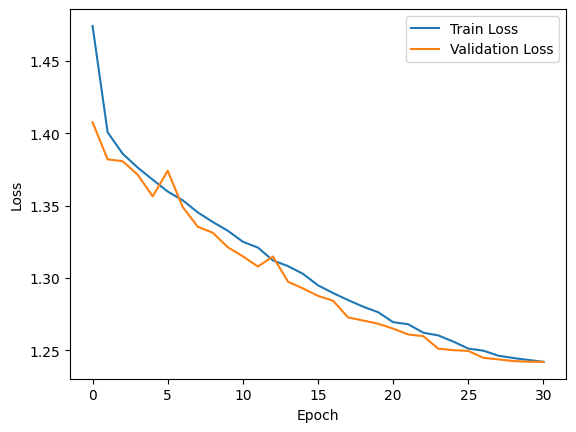

Improved result: acc 0.470, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=30, power=1)
epoch: 30
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.480 | Train Acc:  33.53%
Epoch   0 | Val Loss: 1.422 | Val Acc:  37.10%
learning rate: [0.0009344444444444444]
Epoch   1 | Train Loss: 1.403 | Train Acc:  38.18%
Epoch   1 | Val Loss: 1.388 | Val Acc:  38.92%
learning rate: [0.0008711111111111112]


KeyboardInterrupt: ignored

In [ ]:
trained_gcn = hyperparameter_tuning(model_gcn, strat_train, strat_val, scheduler_list, batch_size = 128)

In [18]:
model_gat = GAT(cv19_graph_data_train.num_node_features,
                cv19_graph_data_train.num_classes*2,
                cv19_graph_data_train.num_classes, heads = 10).to(device)
print(model_gat)

GAT(
  (first_linear): Linear(in_features=50, out_features=50, bias=True)
  (gat_list_1): ModuleList(
    (0-9): 10 x GATv2Conv(50, 5, heads=10)
  )
  (gat_list_2): ModuleList(
    (0-9): 10 x GATv2Conv(50, 5, heads=10)
  )
  (gat_list_3): ModuleList(
    (0-9): 10 x GATv2Conv(50, 5, heads=10)
  )
  (l_list): ModuleList(
    (0-9): 10 x Linear(in_features=50, out_features=1, bias=True)
  )
  (classifier): Linear(in_features=10, out_features=5, bias=True)
)


0.001
[functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=10, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=50, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=100, epochs=300, anneal_strategy='cos')]
batch size: 256
<class 'torch.optim.lr_scheduler.StepLR'>
Epoch   0 | Train Loss: 1.491 | Train Acc:  32.12%
Epoch   0 | Val Loss: 1.407 | Val Acc:  37.85%
learning rate: [0.001]
Epoch   1 | Train Loss: 

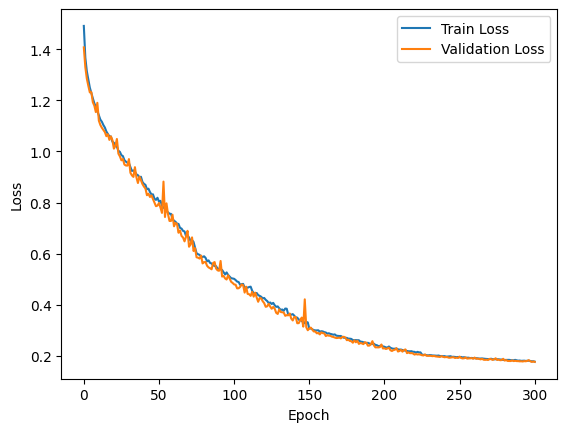

Improved result: acc 0.999, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5)
epoch: 300
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Epoch   0 | Train Loss: 1.489 | Train Acc:  32.52%
Epoch   0 | Val Loss: 1.399 | Val Acc:  37.44%
learning rate: [0.0009999726120980734]
Epoch   1 | Train Loss: 1.362 | Train Acc:  39.80%
Epoch   1 | Val Loss: 1.331 | Val Acc:  41.52%
learning rate: [0.0009998904513956854]
Epoch   2 | Train Loss: 1.312 | Train Acc:  42.35%
Epoch   2 | Val Loss: 1.284 | Val Acc:  44.05%
learning rate: [0.0009997535269026829]
Epoch   3 | Train Loss: 1.274 | Train Acc:  44.40%
Epoch   3 | Val Loss: 1.275 | Val Acc:  44.30%
learning rate: [0.0009995618536343797]
Epoch   4 | Train Loss: 1.251 | Train Acc:  46.05%
Epoch   4 | Val Loss: 1.239 | Val Acc:  45.72%
learning rate: [0.0009993154526099096]
Epoch   5 | Train Loss: 1.227 | Train Acc:  47.10%
Epoch   5 | Val Loss: 1.209 | Val Acc:  48.45%
learning rate: [0.000999014

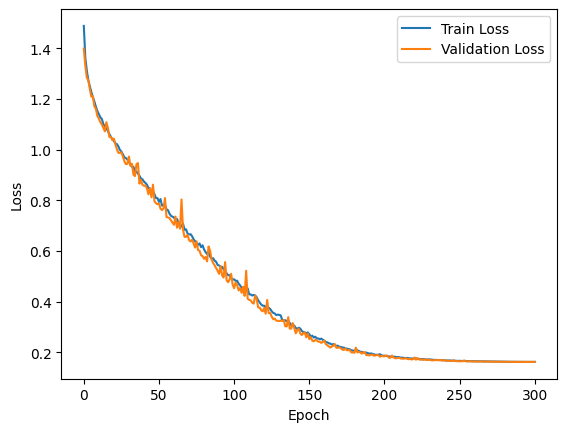

Improved result: acc 1.000, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06)
epoch: 270
<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Epoch   0 | Train Loss: 1.490 | Train Acc:  32.42%
Epoch   0 | Val Loss: 1.400 | Val Acc:  37.10%
learning rate: [0.0009999725874242878]
Epoch   1 | Train Loss: 1.366 | Train Acc:  39.55%
Epoch   1 | Val Loss: 1.339 | Val Acc:  41.11%
learning rate: [0.000999890352703249]
Epoch   2 | Train Loss: 1.310 | Train Acc:  42.58%
Epoch   2 | Val Loss: 1.290 | Val Acc:  43.69%
learning rate: [0.0009997533048548475]
Epoch   3 | Train Loss: 1.281 | Train Acc:  44.17%
Epoch   3 | Val Loss: 1.260 | Val Acc:  45.47%
learning rate: [0.0009995614589079242]
Epoch   4 | Train Loss: 1.249 | Train Acc:  46.09%
Epoch   4 | Val Loss: 1.242 | Val Acc:  46.57%
learning rate: [0.0009993148359005491]
Epoch   5 | Train Loss: 1.229 | Train Acc:  47.16%
Epoch   5 | Val Loss: 1.215 | Val Acc:  47.46%
learning rate: [

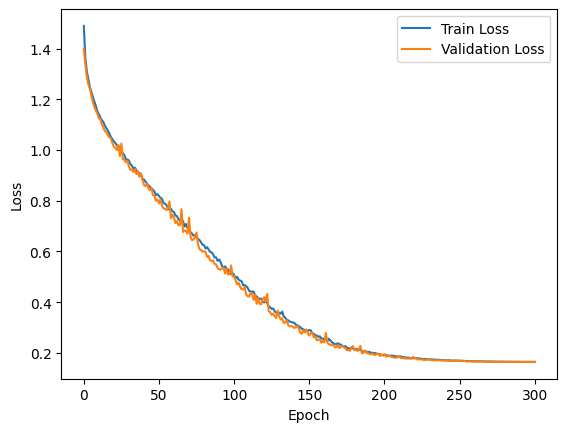

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Epoch   0 | Train Loss: 1.491 | Train Acc:  32.06%
Epoch   0 | Val Loss: 1.421 | Val Acc:  36.39%
learning rate: [0.0009999725849569093]
Epoch   1 | Train Loss: 1.371 | Train Acc:  39.24%
Epoch   1 | Val Loss: 1.331 | Val Acc:  41.59%
learning rate: [0.0009998903428340053]
Epoch   2 | Train Loss: 1.318 | Train Acc:  41.88%
Epoch   2 | Val Loss: 1.288 | Val Acc:  44.09%
learning rate: [0.0009997532826500639]
Epoch   3 | Train Loss: 1.280 | Train Acc:  44.25%
Epoch   3 | Val Loss: 1.258 | Val Acc:  45.24%
learning rate: [0.0009995614194352785]
Epoch   4 | Train Loss: 1.253 | Train Acc:  45.71%
Epoch   4 | Val Loss: 1.232 | Val Acc:  46.71%
learning rate: [0.000999314774229613]
Epoch   5 | Train Loss: 1.233 | Train Acc:  46.62%
Epoch   5 | Val Loss: 1.213 | Val Acc:  48.02%
learning rate: [0.0009990133740804936]
Epoch   6 | Train Loss: 1.208 | Train Acc:  47.95%
Epoch   6 | Val Loss: 1.227 | Val Acc:  46.83%
learning rate: [0.0009986572

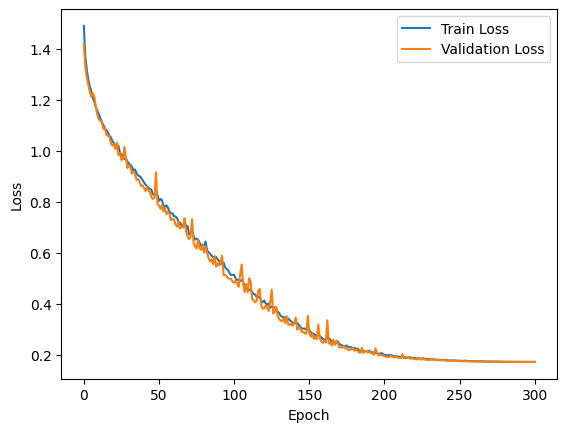

<class 'torch.optim.lr_scheduler.OneCycleLR'>
Epoch   0 | Train Loss: 1.609 | Train Acc:  21.80%
Epoch   0 | Val Loss: 1.566 | Val Acc:  30.08%
learning rate: [7.01709449348317e-05]
Epoch   1 | Train Loss: 1.554 | Train Acc:  30.06%
Epoch   1 | Val Loss: 1.540 | Val Acc:  30.76%
learning rate: [0.00015689092174657438]
Epoch   2 | Train Loss: 1.519 | Train Acc:  31.60%
Epoch   2 | Val Loss: 1.487 | Val Acc:  32.91%
learning rate: [0.000289258165247157]
Epoch   3 | Train Loss: 1.448 | Train Acc:  34.52%
Epoch   3 | Val Loss: 1.406 | Val Acc:  37.38%
learning rate: [0.00045063248870811506]
Epoch   4 | Train Loss: 1.376 | Train Acc:  39.09%
Epoch   4 | Val Loss: 1.347 | Val Acc:  40.45%
learning rate: [0.0006207271595167973]
Epoch   5 | Train Loss: 1.327 | Train Acc:  41.60%
Epoch   5 | Val Loss: 1.298 | Val Acc:  42.85%
learning rate: [0.0007781591903953822]
Epoch   6 | Train Loss: 1.287 | Train Acc:  43.90%
Epoch   6 | Val Loss: 1.290 | Val Acc:  43.45%
learning rate: [0.0009031374432829

ValueError: ignored

In [37]:
epochs = 300
# da rifare esperimenti col polinomial 2
# training information from stepLR (2) to CosineAnnealing
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, strat_train, strat_val, scheduler_list, batch_size = 256, epochs = epochs)

0.001
[functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=1), functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=2), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=75, gamma=0.5), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-06), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-07), functools.partial(<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>, T_max=300, eta_min=1e-08), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=10, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>, max_lr=0.001, steps_per_epoch=50, epochs=300, anneal_strategy='cos'), functools.partial(<class 'torch.optim.lr_scheduler.OneCycleLR'>

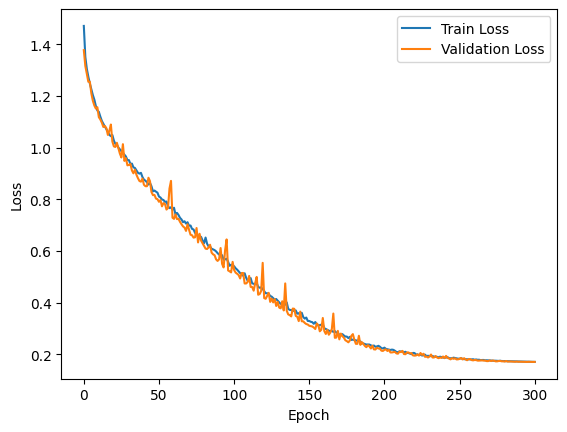

Improved result: acc 1.000, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.PolynomialLR'>, total_iters=300, power=1)
epoch: 292
<class 'torch.optim.lr_scheduler.PolynomialLR'>
Epoch   0 | Train Loss: 1.478 | Train Acc:  33.35%
Epoch   0 | Val Loss: 1.384 | Val Acc:  38.78%
learning rate: [0.0009933444444444445]
Epoch   1 | Train Loss: 1.357 | Train Acc:  39.65%
Epoch   1 | Val Loss: 1.322 | Val Acc:  42.11%
learning rate: [0.0009867111111111111]
Epoch   2 | Train Loss: 1.308 | Train Acc:  42.70%
Epoch   2 | Val Loss: 1.288 | Val Acc:  43.89%
learning rate: [0.0009801000000000002]
Epoch   3 | Train Loss: 1.274 | Train Acc:  44.38%
Epoch   3 | Val Loss: 1.251 | Val Acc:  45.90%
learning rate: [0.0009735111111111113]
Epoch   4 | Train Loss: 1.250 | Train Acc:  45.90%
Epoch   4 | Val Loss: 1.233 | Val Acc:  47.17%
learning rate: [0.0009669444444444444]
Epoch   5 | Train Loss: 1.226 | Train Acc:  47.36%
Epoch   5 | Val Loss: 1.206 | Val Acc:  48.38%
learning rate: [0.0009604

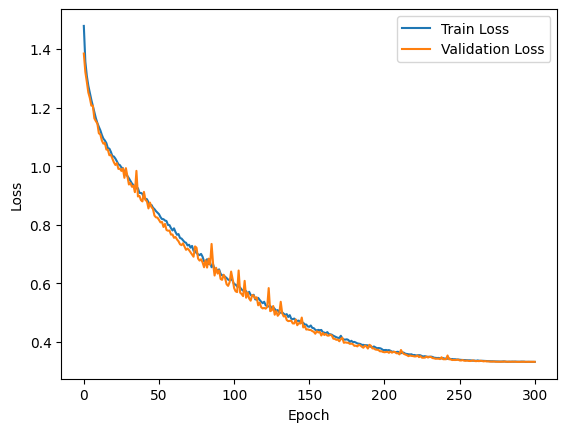

<class 'torch.optim.lr_scheduler.StepLR'>
Epoch   0 | Train Loss: 1.480 | Train Acc:  33.02%
Epoch   0 | Val Loss: 1.390 | Val Acc:  38.50%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.360 | Train Acc:  39.78%
Epoch   1 | Val Loss: 1.328 | Val Acc:  41.67%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.309 | Train Acc:  42.64%
Epoch   2 | Val Loss: 1.281 | Val Acc:  44.12%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.277 | Train Acc:  44.43%
Epoch   3 | Val Loss: 1.254 | Val Acc:  45.77%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.249 | Train Acc:  45.86%
Epoch   4 | Val Loss: 1.237 | Val Acc:  46.88%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.230 | Train Acc:  47.09%
Epoch   5 | Val Loss: 1.209 | Val Acc:  48.23%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.206 | Train Acc:  48.33%
Epoch   6 | Val Loss: 1.185 | Val Acc:  49.62%
learning rate: [0.001]
Epoch   7 | Train Loss: 1.183 | Train Acc:  49.33%
Epoch   7 | Val Loss: 1.168 | Val Acc:  50.79%
learning rate

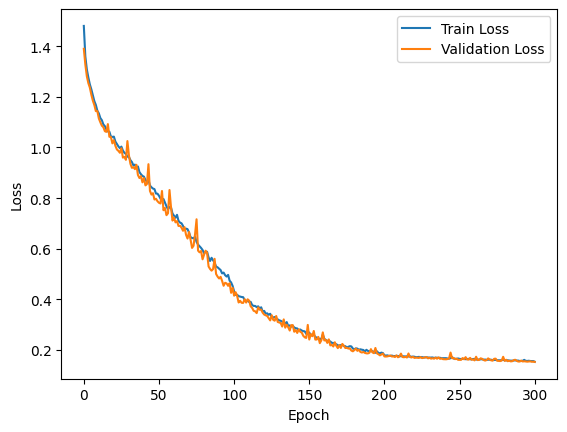

Improved result: acc 1.000, scheduler:
 functools.partial(<class 'torch.optim.lr_scheduler.StepLR'>, step_size=100, gamma=0.5)
epoch: 250
<class 'torch.optim.lr_scheduler.StepLR'>
Epoch   0 | Train Loss: 1.471 | Train Acc:  33.58%
Epoch   0 | Val Loss: 1.381 | Val Acc:  39.08%
learning rate: [0.001]
Epoch   1 | Train Loss: 1.356 | Train Acc:  40.08%
Epoch   1 | Val Loss: 1.325 | Val Acc:  41.96%
learning rate: [0.001]
Epoch   2 | Train Loss: 1.310 | Train Acc:  42.40%
Epoch   2 | Val Loss: 1.290 | Val Acc:  43.44%
learning rate: [0.001]
Epoch   3 | Train Loss: 1.275 | Train Acc:  44.70%
Epoch   3 | Val Loss: 1.262 | Val Acc:  45.11%
learning rate: [0.001]
Epoch   4 | Train Loss: 1.248 | Train Acc:  46.08%
Epoch   4 | Val Loss: 1.228 | Val Acc:  47.30%
learning rate: [0.001]
Epoch   5 | Train Loss: 1.228 | Train Acc:  47.14%
Epoch   5 | Val Loss: 1.210 | Val Acc:  48.19%
learning rate: [0.001]
Epoch   6 | Train Loss: 1.206 | Train Acc:  48.16%
Epoch   6 | Val Loss: 1.190 | Val Acc:  49.

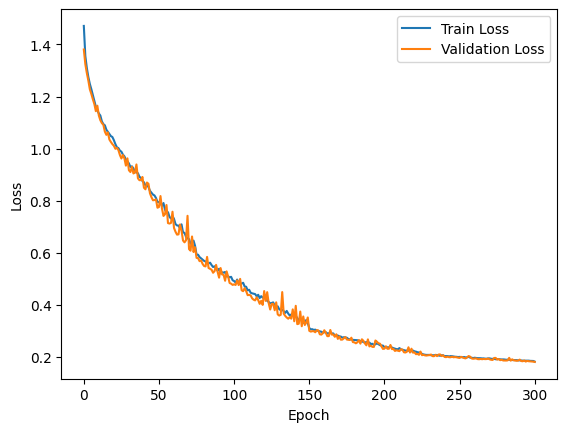

<class 'torch.optim.lr_scheduler.CosineAnnealingLR'>
Epoch   0 | Train Loss: 1.476 | Train Acc:  33.53%
Epoch   0 | Val Loss: 1.383 | Val Acc:  38.92%
learning rate: [0.0009999726120980734]
Epoch   1 | Train Loss: 1.357 | Train Acc:  40.22%
Epoch   1 | Val Loss: 1.323 | Val Acc:  42.20%
learning rate: [0.0009998904513956854]
Epoch   2 | Train Loss: 1.310 | Train Acc:  42.74%
Epoch   2 | Val Loss: 1.286 | Val Acc:  43.94%
learning rate: [0.0009997535269026829]
Epoch   3 | Train Loss: 1.277 | Train Acc:  44.47%
Epoch   3 | Val Loss: 1.261 | Val Acc:  45.32%
learning rate: [0.0009995618536343797]
Epoch   4 | Train Loss: 1.258 | Train Acc:  44.99%
Epoch   4 | Val Loss: 1.234 | Val Acc:  46.86%
learning rate: [0.0009993154526099096]
Epoch   5 | Train Loss: 1.232 | Train Acc:  46.88%
Epoch   5 | Val Loss: 1.213 | Val Acc:  48.00%
learning rate: [0.0009990143508499217]
Epoch   6 | Train Loss: 1.212 | Train Acc:  48.10%
Epoch   6 | Val Loss: 1.197 | Val Acc:  48.77%
learning rate: [0.000998658

In [ ]:
# training information for polynomialLR to stepLR
epochs = 300
print(get_lr(model_gat.optimizer))
scheduler_list = build_scheduler_list(epochs=epochs)
print(scheduler_list)
trained_gat = hyperparameter_tuning(model_gat, strat_train, strat_val, scheduler_list, batch_size = 256, epochs = epochs)